# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [67]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [68]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [69]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [70]:
from asl_utils import test_features_tryit
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [71]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [72]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [73]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [74]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [75]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean']= asl.df['speaker'].map(df_means['left-y'])
asl.df['grnd-lx-mean']= asl.df['speaker'].map(df_means['grnd-lx'])
asl.df['grnd-ly-mean']= asl.df['speaker'].map(df_means['grnd-ly'])
asl.df['right-x-mean']= asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean']= asl.df['speaker'].map(df_means['right-y'])
asl.df['grnd-rx-mean']= asl.df['speaker'].map(df_means['grnd-rx'])
asl.df['grnd-ry-mean']= asl.df['speaker'].map(df_means['grnd-ry'])


asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  left-y-mean  \
video frame                                                                 
98    0          113        9      119      -12   164.661438   161.271242   
      1          113        9      119      -12   164.661438   161.271242   
      2          113        9      119      -12   164.661438   161.271242   
      3          113        9      119      -12   164.661438   161.271242   
      4          113        9      119      -12   164.661438   161.271242   

             grnd-lx-mean  grnd-ly-mean  right-x-mean  right-y-mean  \
video frame                                                           
98    0          2.006318    104.026144    151.017865    117.332462   
      1          2.006318    104.026144    151.017865    117.332462   
      2          2.006318    104.026144    151.017865    117.332462   
      3          2.006318    104.026144    151.017865    117.332462   
      4          2.006318    104.026144    151.017865    117.332462   

             grnd-rx-mean  grnd-ry-mean  
video frame                              
98    0        -11.637255     60.087364  
      1        -11.637255     60.087364  
      2        -11.637255     60.087364  
      3        -11.637255     60.087364  
      4        -11.637255     60.087364

##### Try it!

In [76]:
from asl_utils import test_std_tryit
df_std = asl.df.groupby('speaker').std()
# test the code
asl.df['left-x-std']= asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std']= asl.df['speaker'].map(df_std['left-y'])
asl.df['grnd-lx-std']= asl.df['speaker'].map(df_std['grnd-lx'])
asl.df['grnd-ly-std']= asl.df['speaker'].map(df_std['grnd-ly'])
asl.df['right-x-std']= asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std']= asl.df['speaker'].map(df_std['right-y'])
asl.df['grnd-rx-std']= asl.df['speaker'].map(df_std['grnd-rx'])
asl.df['grnd-ry-std']= asl.df['speaker'].map(df_std['grnd-ry'])

test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean,left-y-mean,grnd-lx-mean,grnd-ly-mean,right-x-mean,right-y-mean,grnd-rx-mean,grnd-ry-mean
speaker,,,,,,,,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [77]:
# Add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['norm-rx'] = (asl.df['right-x']-asl.df['right-x-mean'])/asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y']-asl.df['right-y-mean'])/asl.df['right-y-std']
asl.df['norm-lx'] = (asl.df['left-x']-asl.df['left-x-mean'])/asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y']-asl.df['left-y-mean'])/asl.df['left-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [78]:
# Add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle
def cartesianToPolar(x, y):
    """Returns radius and angle"""
    pRadius = np.sqrt(np.square(x)+np.square(y))
    pAngle = np.arctan2(x, y)
    return pRadius, pAngle

polar_rr, polar_rtheta = cartesianToPolar(asl.df['grnd-rx'], asl.df['grnd-ry'])
polar_lr, polar_ltheta = cartesianToPolar(asl.df['grnd-lx'], asl.df['grnd-ly'])
asl.df['polar-rr'] = polar_rr
asl.df['polar-rtheta'] = polar_rtheta
asl.df['polar-lr'] = polar_lr
asl.df['polar-ltheta'] = polar_ltheta
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [79]:
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df['right-x'].diff()
asl.df['delta-ry'] = asl.df['right-y'].diff()
asl.df['delta-lx'] = asl.df['left-x'].diff()
asl.df['delta-ly'] = asl.df['left-y'].diff()

asl.df['delta-rx'].fillna(0, inplace=True)
asl.df['delta-ry'].fillna(0, inplace=True)
asl.df['delta-lx'].fillna(0, inplace=True)
asl.df['delta-ly'].fillna(0, inplace=True)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [80]:
# Add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
asl.df['custom-rx'] = (asl.df['grnd-rx']-asl.df['grnd-rx-mean'])/asl.df['grnd-rx-std']
asl.df['custom-ry'] = (asl.df['grnd-ry']-asl.df['grnd-ry-mean'])/asl.df['grnd-ry-std']
asl.df['custom-lx'] = (asl.df['grnd-lx']-asl.df['grnd-lx-mean'])/asl.df['grnd-lx-std']
asl.df['custom-ly'] = (asl.df['grnd-ly']-asl.df['grnd-ly-mean'])/asl.df['grnd-ly-std']

# Take delta of above
asl.df['custom-delta-rx'] = asl.df['custom-rx'].diff()
asl.df['custom-delta-ry'] = asl.df['custom-ry'].diff()
asl.df['custom-delta-lx'] = asl.df['custom-lx'].diff()
asl.df['custom-delta-ly'] = asl.df['custom-ly'].diff()

asl.df['custom-delta-rx'].fillna(0, inplace=True)
asl.df['custom-delta-ry'].fillna(0, inplace=True)
asl.df['custom-delta-lx'].fillna(0, inplace=True)
asl.df['custom-delta-ly'].fillna(0, inplace=True)

# TODO define a list named 'features_custom' for building the training set
features_custom = ['custom-delta-rx', 'custom-delta-ry', 'custom-delta-lx', 'custom-delta-ly']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I started by taking the norm of the ground values (With respect to the nose) because this reduces error caused by differences in the speaker's height. This should make all of the data slightly easier to normalize, since the origin is more central to the individual speaker. I then chose to take the delta of each normalized ground value, since this takes into account the immediate next frame, hopefully giving more context and making the model easier to train.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [81]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.025s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [82]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [83]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [84]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 6, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 6
hidden state #0
mean =  [   3.32090354   86.11783896   12.66977644  102.36983493]
variance =  [ 12.48269266   7.43528296  12.8641019   24.73749611]

hidden state #1
mean =  [ -8.22222307  51.88888848   6.          69.        ]
variance =  [  9.06283787e+00   1.43320928e+00   1.11111135e-03   1.11111135e-03]

hidden state #2
mean =  [ -6.70724054  63.61794592   4.92582527  85.82020616]
variance =  [ 30.12320855  82.03280313  21.69925611  83.38913158]

hidden state #3
mean =  [  -7.70661407   93.36390122   12.99293408  127.06344937]
variance =  [ 29.53969265  13.52111958   0.66764747  48.4388134 ]

hidden state #4
mean =  [ -5.67200656  63.50085077   1.79912754  83.30021812]
variance =  [ 4.81899404  9.60606282  3.36217488  0.2108669 ]

hidden state #5
mean =  [  -6.95537897   49.68391588    3.77778556  107.5884027 ]
variance =  [ 11.89715016   5.39373548  34.8758451   96.62732487]

logL = -427.23856122684066


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [85]:
%matplotlib inline

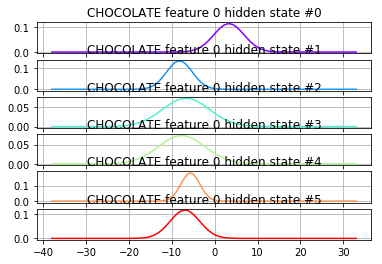

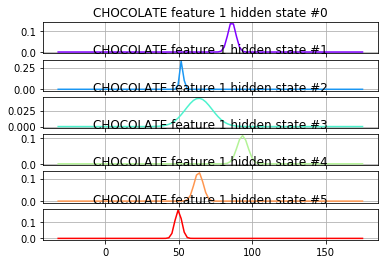

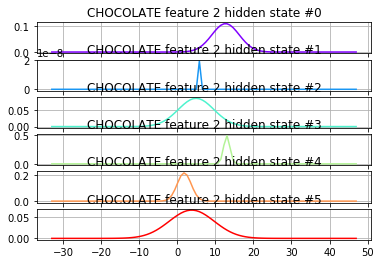

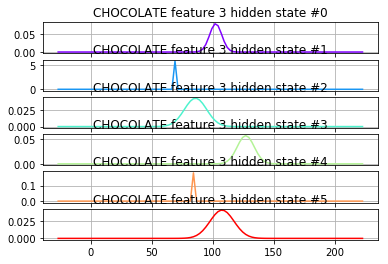

In [86]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [87]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'CHICKEN' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHICKEN is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [88]:
from sklearn.model_selection import KFold

training = asl.build_training(features_norm) # Experiment here with different feature sets
word = 'CHOCOLATE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[1 2] Test fold indices:[0]
Train fold indices:[0 2] Test fold indices:[1]
Train fold indices:[0 1] Test fold indices:[2]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [89]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [90]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.016512579983100295 seconds
Training complete for BOOK with 5 states with time 3.7247450510039926 seconds
Training complete for VEGETABLE with 2 states with time 1.4694231789908372 seconds
Training complete for FUTURE with 2 states with time 3.8431806809967384 seconds
Training complete for JOHN with 12 states with time 39.61831210803939 seconds


In [92]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.07624322496121749 seconds
Training complete for BOOK with 8 states with time 1.8803552790195681 seconds
Training complete for VEGETABLE with 9 states with time 0.6850472749792971 seconds
Training complete for FUTURE with 9 states with time 2.032669974025339 seconds
Training complete for JOHN with 14 states with time 19.67650883400347 seconds


In [93]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 0.5420231920434162 seconds
Training complete for BOOK with 15 states with time 3.8718138970434666 seconds
Training complete for VEGETABLE with 15 states with time 3.2619894969975576 seconds
Training complete for FUTURE with 15 states with time 4.422250094998162 seconds
Training complete for JOHN with 15 states with time 21.718693481991068 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

The first model selector used, Cross Validation, is interesting because it takes multiple folds of itself to identify the best sequence. This works extremely well when the word has few states, but a more complex word like JOHN took almost twice as long to train than the other selectors. The reason for this is likely because every state added essentially means exponentially more loops necessary to get the possible sequences derrived from KFold. It's worth noting that JOHN will take much longer than any of the other examples purely because there are way more training examples for that specific word.
In addition to this, CV had a tendency to over-simplify the states. A word like VEGETABLE has too many different motions involved to be simplified down to 2 states.

The BIC selector visually appears to be the most normalized selector, seeming to take a relatively short amount of time all accross the board, but also training words with a number of states that seem appropriate for their complexity. BIC also seems to be more consistent with the number of states for each word. Generally this could be a good thing, since you reduce the possibility of over-simplifying hence misclassifying words. However the downside with this seemingly more "normal" approach is that it might not work for all words.

I thought it was interesting that BOOK and FUTURE were trained with so many states with the DIC selector. I think the advantage with DIC is that you could possibly increase accuracy with added complexity, but on the other hand (no pun intended), these additional states may be unecessary. 

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [94]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 143.862s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [95]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant) # Experiment here with different feature sets defined in part 1
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [96]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [97]:
from my_recognizer import recognize
from asl_utils import show_errors

In [98]:
model_selector = SelectorCV

features = features_ground 
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
ground_CV_WER = show_errors(guesses, test_set)

features = features_norm
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
norm_CV_WER = show_errors(guesses, test_set)

features = features_polar
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
polar_CV_WER = show_errors(guesses, test_set)

features = features_delta
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
delta_CV_WER = show_errors(guesses, test_set)

features = features_custom
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
custom_CV_WER = show_errors(guesses, test_set)


**** WER = 0.5955056179775281
Total correct: 72 out of 178
Video  Recognized                                                    Correct
    2: *WHO WRITE *ARRIVE                                            JOHN WRITE HOMEWORK
    7: JOHN CAN *IX *HAVE                                            JOHN CAN GO CAN
   12: *WOMAN *CAR *WHAT *WHAT                                       JOHN CAN GO CAN
   21: JOHN *HOMEWORK *FUTURE *PREFER *CAR *CAR *VISIT *WHO          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE *LOVE *TELL *LOVE                                   JOHN LIKE IX IX IX
   28: JOHN *TELL *LOVE *LIKE *LOVE                                  JOHN LIKE IX IX IX
   30: *SHOULD LIKE *MARY *MARY IX                                   JOHN LIKE IX IX IX
   36: MARY VEGETABLE *IX *MARY *MARY *MARY                          MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *APPLE *JOHN *MARY                                 JOHN IX THINK MARY LOVE
   43: JOHN *SHOULD BUY HOUSE       


**** WER = 0.6067415730337079
Total correct: 70 out of 178
Video  Recognized                                                    Correct
    2: *IX *IX HOMEWORK                                              JOHN WRITE HOMEWORK
    7: JOHN *FINISH *GIVE1 *TEACHER                                  JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *BUY *NEW *YESTERDAY *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *MARY *MARY IX *MARY                                     JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX IX                                        JOHN LIKE IX IX IX
   30: JOHN *MARY IX *JOHN IX                                        JOHN LIKE IX IX IX
   36: *JOHN *JOHN *IX *GIVE *MARY *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

In [99]:
model_selector = SelectorBIC

features = features_ground 
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
ground_BIC_WER = show_errors(guesses, test_set)

features = features_norm
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
norm_BIC_WER = show_errors(guesses, test_set)

features = features_polar
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
polar_BIC_WER = show_errors(guesses, test_set)

features = features_delta
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
delta_BIC_WER = show_errors(guesses, test_set)

features = features_custom
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
custom_BIC_WER = show_errors(guesses, test_set)


**** WER = 0.5561797752808989
Total correct: 79 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE *NEW                                               JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *BOX GO *ARRIVE                                JOHN CAN GO CAN
   12: *IX *WHAT *CAN CAN                                            JOHN CAN GO CAN
   21: JOHN *WRITE *JOHN *FUTURE *CAR *TEACHER *VISIT *MARY          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *LIKE IX                                          JOHN LIKE IX IX IX
   28: JOHN *WHO IX *LIKE *LOVE                                      JOHN LIKE IX IX IX
   30: JOHN LIKE *MARY *MARY *MARY                                   JOHN LIKE IX IX IX
   36: *VISIT *VISIT *IX *GIVE *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           


**** WER = 0.6179775280898876
Total correct: 68 out of 178
Video  Recognized                                                    Correct
    2: JOHN *LOVE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *STUDENT *GIVE1 *STUDENT                                 JOHN CAN GO CAN
   12: JOHN CAN *GO1 CAN                                             JOHN CAN GO CAN
   21: *MARY *MARY WONT *MARY *CAR *TOMORROW *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *MARY IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX IX *JOHN IX                                          JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX *FINISH HOUSE       

In [100]:
model_selector = SelectorDIC

features = features_ground 
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
ground_DIC_WER = show_errors(guesses, test_set)

features = features_norm
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
norm_DIC_WER = show_errors(guesses, test_set)

features = features_polar
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
polar_DIC_WER = show_errors(guesses, test_set)

features = features_delta
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
delta_DIC_WER = show_errors(guesses, test_set)

features = features_custom
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
custom_DIC_WER = show_errors(guesses, test_set)


**** WER = 0.5730337078651685
Total correct: 76 out of 178
Video  Recognized                                                    Correct
    2: JOHN *NEW *GIVE1                                              JOHN WRITE HOMEWORK
    7: *SOMETHING-ONE *CAR *ARRIVE *ARRIVE                           JOHN CAN GO CAN
   12: *IX *WHAT *WHAT *CAR                                          JOHN CAN GO CAN
   21: JOHN *GIVE1 *JOHN *FUTURE *CAR *CAR *FUTURE *MARY             JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX IX *WHO IX                                           JOHN LIKE IX IX IX
   28: JOHN *WHO IX IX *LOVE                                         JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *VISIT *VISIT *GIVE *GO *MARY *IX                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY *GO *GIVE MARY *MARY                                    JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           


**** WER = 0.6292134831460674
Total correct: 66 out of 178
Video  Recognized                                                    Correct
    2: JOHN *GIVE1 *ARRIVE                                           JOHN WRITE HOMEWORK
    7: JOHN *GIVE1 *GIVE1 *ARRIVE                                    JOHN CAN GO CAN
   12: JOHN *BOX *JOHN CAN                                           JOHN CAN GO CAN
   21: JOHN *MARY *LOVE *MARY *HOUSE *FUTURE *FUTURE *MARY           JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN *IX *JOHN IX IX                                          JOHN LIKE IX IX IX
   28: JOHN *MARY *JOHN IX *SHOULD                                   JOHN LIKE IX IX IX
   30: JOHN *IX *SHOULD *JOHN IX                                     JOHN LIKE IX IX IX
   36: *JOHN *JOHN *JOHN IX *MARY *MARY                              MARY VEGETABLE KNOW IX LIKE CORN1
   40: *MARY IX *JOHN MARY *MARY                                     JOHN IX THINK MARY LOVE
   43: JOHN *IX BUY HOUSE           

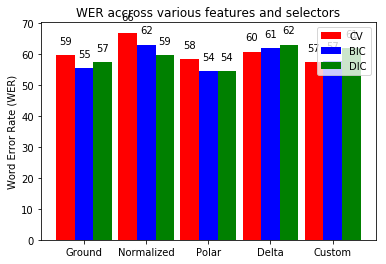

In [101]:
# I have decided to gather all of the data and plot it in a simple bar chart.
import matplotlib.pyplot as plt
N = 5
CV = (ground_CV_WER * 100, norm_CV_WER * 100, polar_CV_WER * 100, delta_CV_WER * 100, custom_CV_WER * 100)

ind = np.arange(N)  # the x locations for the groups
width = 0.30       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, CV, width, color='r')

BIC = (ground_BIC_WER * 100, norm_BIC_WER * 100, polar_BIC_WER * 100, delta_BIC_WER * 100, custom_BIC_WER * 100)
rects2 = ax.bar(ind + width, BIC, width, color='b')

DIC = (ground_DIC_WER * 100, norm_DIC_WER * 100, polar_DIC_WER * 100, delta_DIC_WER * 100, custom_DIC_WER * 100)
rects3 = ax.bar(ind + width + width, DIC, width, color='g')


# add some text for labels, title and axes ticks
ax.set_ylabel('Word Error Rate (WER)')
ax.set_title('WER accross various features and selectors')
ax.set_xticks(ind + width*2 / 2)
ax.set_xticklabels(('Ground', 'Normalized', 'Polar', 'Delta', 'Custom'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('CV', 'BIC', 'DIC'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
Intead of three combinations I decided to try all possible combinations of features and selectors. In one specific test case, the best performants were generally DIC and BIC selectors. The "best" overall was Polar features with DIC or BIC selectors, both at an average of 54% WER. I think the main reason that DIC and BIC selectors generally did better than Cross Validation is that CV reduces the amount of training data available, and in this case, there are not enough training examples to use as validation without affecting negatively affecting the training.

It was interesting that the Delta seemed to have such a high WER, however when getting the delta of normalized ground values, the selectors performed much better. This is likely because there is too much variance in delta's from one speaker to the next, due to height and arm length. When one normalizes the data and uses the nose as an origin point, the deltas from speaker to speaker will probably be closer together, making the recognizer more accurate.

The biggest improvement I could make to the WER would be to introduce Language Models. By using the probabilities of both general occurrences of the word and occurrences of a word directly after the use of another specific word, I could eliminate a lot of WER. Another similar technique would take some of the grammatical rules of ASL, and loosely apply them to the recognizer, heavily penalizing the guesses that shouldn't be able to occur grammatically.


<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [102]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 89.274s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()